# Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

# Importing data

In [2]:
features = pd.read_csv('data/features.csv')
train = pd.read_csv('data/train.csv')

In [3]:
features.head(5)

,feature,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28
0,feature_0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,feature_1,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,feature_2,False,False,False,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
3,feature_3,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False
4,feature_4,False,False,False,False,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


In [44]:
#one hot encode features (True---> 1 and Flase---> 0)
feature_column = features[['feature']]
features_hot = features.apply(LabelEncoder().fit_transform)
features_hot.drop(columns=['feature'],inplace=True)
features_hot = pd.concat([feature_column,features_hot],axis=1)
features_hot.tail(5)

,feature,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,...,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24,tag_25,tag_26,tag_27,tag_28
125,feature_125,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
126,feature_126,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
127,feature_127,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
128,feature_128,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
129,feature_129,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [49]:
array_1 = features_hot.loc[features.feature == 'feature_0'].values[0]

In [50]:
array_1 = np.delete(array_1, 0)

In [83]:
def find_all_false(data,feature,array_1):
    array_feat = data.loc[data.feature == feature].values[0]
    array_feat = np.delete(array_feat,0)
    if np.array_equal(array_feat,array_1):
        print('True: ', feature)
        return(True, feature)
    else:
        print('no')
        return False

In [86]:
# answer
# for i in range(1,130):
#     find_all_false(features_hot,f'feature_{i}',array_1)

In [5]:
# creating action and profit columns
# action=1 shows positive resp which possible means buy or sell
# action=0 shows negative res which possibly mean neither buy nor sell
# profit is response times weight
train['action'] = (train['resp'].values > 0).astype('int')
train['profit'] = train['resp'].multiply(train['weight'])

# EDA

### Shape of the data and brief description (mean, median, std and ...)

In [6]:
# print the shape of train and features data
print('shape of train data: ', train.shape)
print('shape of feature_hot data: ', features_hot.shape)
print('brief description of the data:\n')
train.describe().transpose()

shape of train data:  (2390491, 140)
shape of feature_hot data:  (130, 30)
brief description of the data:



,count,mean,std,min,25%,50%,75%,max
date,2390491.0,2.478668e+02,152.274630,0.000000,104.000000,2.540000e+02,3.820000e+02,4.990000e+02
weight,2390491.0,3.031535e+00,7.672794,0.000000,0.161740,7.086770e-01,2.471791e+00,1.672937e+02
resp_1,2390491.0,1.434969e-04,0.008930,-0.367504,-0.001859,4.552665e-05,2.097469e-03,2.453477e-01
resp_2,2390491.0,1.980749e-04,0.012302,-0.532833,-0.002655,6.928179e-05,2.939111e-03,2.949339e-01
resp_3,2390491.0,2.824183e-04,0.019069,-0.568120,-0.005031,1.164734e-04,5.466336e-03,3.265597e-01
...,...,...,...,...,...,...,...,...
feature_128,2388570.0,3.425608e-01,2.307130,-7.024909,-1.278341,8.563069e-17,1.582633e+00,5.119038e+01
feature_129,2388570.0,2.456182e-01,1.765419,-5.282181,-0.854453,4.869529e-17,1.125321e+00,1.164568e+02
ts_id,2390491.0,1.195245e+06,690075.455512,0.000000,597622.500000,1.195245e+06,1.792868e+06,2.390490e+06
action,2390491.0,5.040697e-01,0.499984,0.000000,0.000000,1.000000e+00,1.000000e+00,1.000000e+00


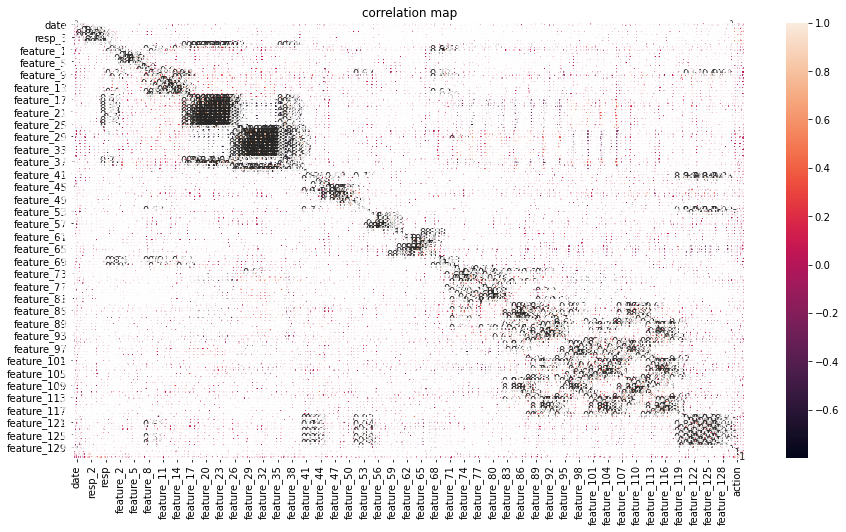

In [8]:
# #correlation of all data
# plt.figure(figsize=(15,8))
# corr_matrix = train.corr()
# ax = sns.heatmap(corr_matrix, annot=True)
# ax.set_title('correlation map')
# plt.show()

cannot infer much information from this correlation map as the number of features are high!!

### Number of trades per day

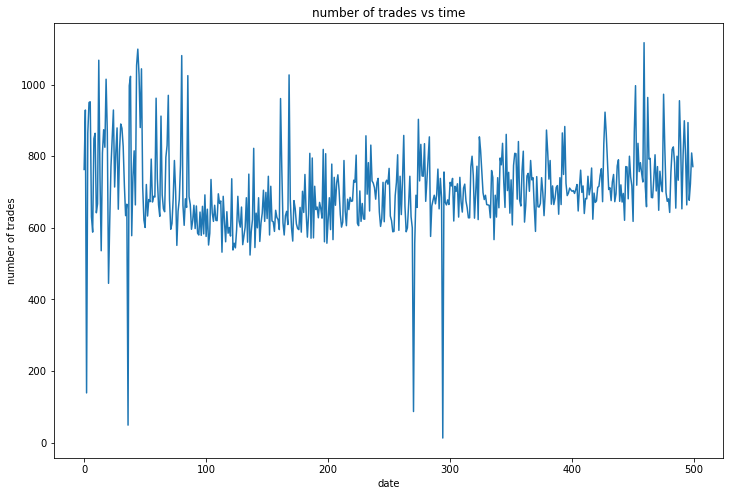

In [7]:
plt.figure(figsize=(12,8))
plt.xlabel('date')
plt.ylabel('number of trades')
plt.title('number of trades vs time')
plt.plot(train.groupby('date')['feature_41'].nunique())
plt.show()

approximately 700 trades per day

### Number of oppurtunites and percentage of trades

In [8]:
#total number of oppurtunities for day zero
nb_opportunities = train.query('date==0').feature_41.shape[0]
print('total number of oppurtunities for day zero: ',nb_opportunities)
#total
count_f41 = train.query('date==0').feature_41.value_counts()
nb_stock = count_f41.values.shape[0]
above_fifty = np.argmax(count_f41.cumsum().values/nb_opportunities > 0.5)
print(above_fifty)
print(nb_stock)

total number of oppurtunities for day zero:  5587
82
763


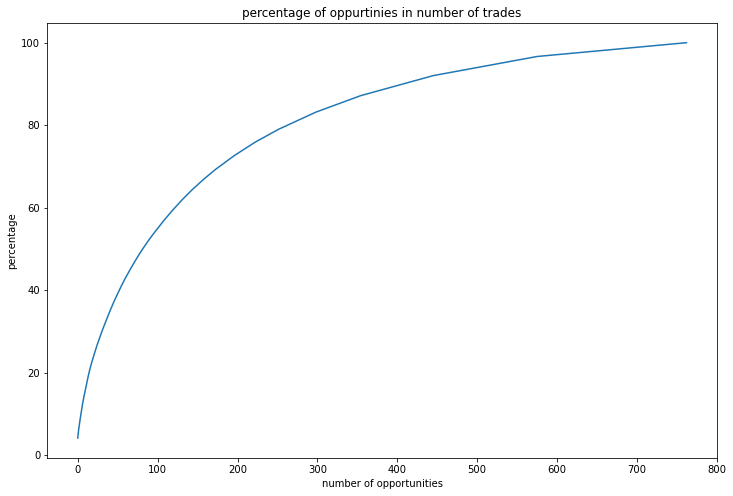

In [9]:
plt.figure(figsize=(12,8))
plt.xlabel('number of opportunities')
plt.ylabel('percentage')
plt.title('percentage of oppurtinies in number of trades')
plt.plot(count_f41.cumsum().values/nb_opportunities*100)
plt.show()

In [10]:
nth_day = 0
train_fd = train.query('date=='+str(nth_day)).copy()

nth_most_common = 0
value  = train_fd.feature_41.value_counts().index[nth_most_common]
df_md = train_fd[train_fd.feature_41 == value]

In [11]:
df_md.head(5)

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action,profit
131,0,0.322272,-0.012919,0.029867,0.099392,0.105460,0.060714,1,-3.172026,-3.093182,...,-3.792053,2.209790,-2.154812,2.940261,-1.669132,1.328792,-2.343079,131,1,0.019567
132,0,0.427561,-0.007480,0.020343,0.102174,0.109823,0.063493,1,-3.172026,-3.093182,...,-2.092762,2.220983,-2.153498,2.965475,-1.661276,1.639023,-2.129153,132,1,0.027147
150,0,0.414218,-0.005072,0.024909,0.125783,0.105442,0.062854,1,-0.223407,-1.835836,...,-2.499977,2.039261,-2.410264,2.545040,-1.955018,1.936977,-1.933912,150,1,0.026035
242,0,0.292854,-0.005608,-0.045858,-0.125826,-0.120232,-0.082854,-1,-3.172026,-3.093182,...,-1.553304,3.444598,-0.535025,5.637950,0.199727,4.157197,-0.426872,242,0,-0.024264
266,0,0.668670,0.009368,0.047068,0.114879,0.118407,0.077068,1,9.688915,3.997000,...,-0.851445,3.402263,-0.608560,5.108131,-0.168423,3.487062,-0.975299,266,1,0.051533


In [12]:
def plot_cols(data, columns):
    for i in columns:
        fig, ax = plt.subplots()
        colors = {0:'red', 1:'blue'}
        markers = {-1:'x', 1:'o'}

        x = data.index
        y = data[i]
        c = data['action'].map(colors)
        m = data['feature_0'].map(markers)

        unique_markers = set(m)  # or yo can use: np.unique(m)
        for um in unique_markers:
            mask = m == um
            # mask is now an array of booleans that can be used for indexing  
            ax.scatter(x[mask], y[mask], c=c[mask], marker=um)
            ax.set_title(str(i)+' vs index')
            ax.set_xlabel('index')
            ax.set_ylabel(str(i))
        plt.show()

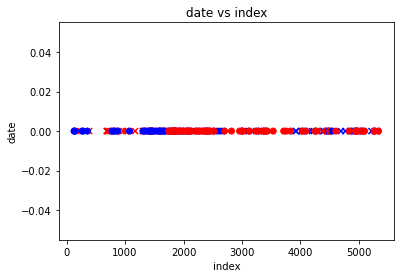

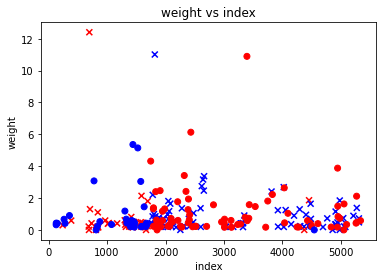

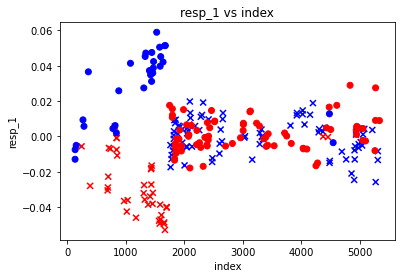

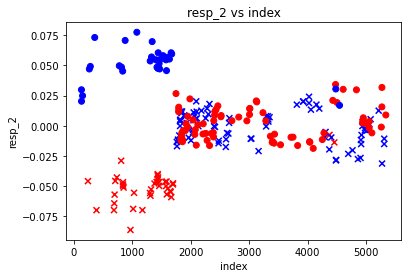

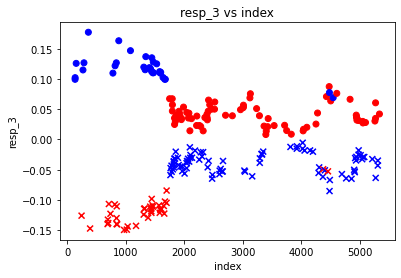

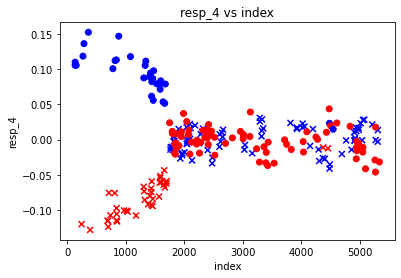

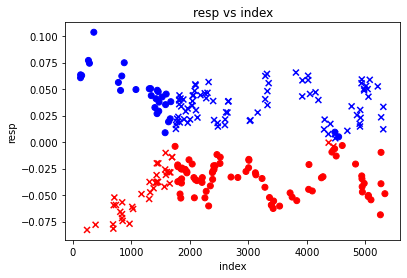

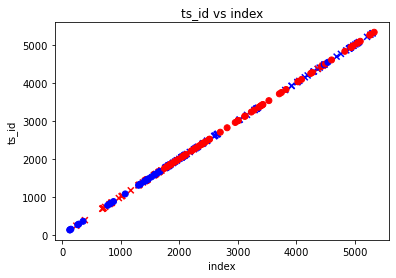

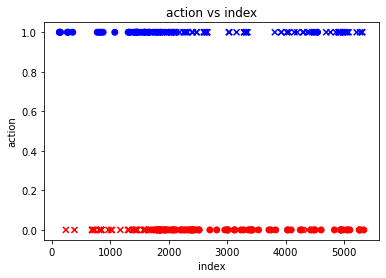

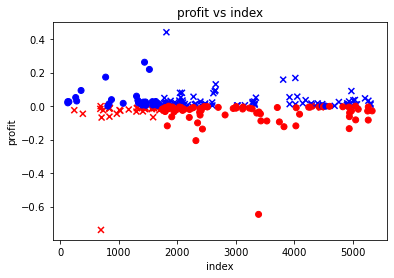

In [13]:
plot_cols(df_md, ['date','weight','resp_1','resp_2','resp_3','resp_4','resp','ts_id','action','profit'])

In [14]:
df_md_f0 = df_md.multiply(df_md['feature_0'],axis=0)
df_md_f0['action'] = df_md['action']
df_md_f0['ts_id'] = df_md['ts_id']
df_md_f0['feature_0'] = df_md['feature_0']
df_md_f0['weight'] = df_md['weight']
df_md_f0['profit'] = df_md['profit']

In [15]:
df_md_f0.head(5)

,date,weight,resp_1,resp_2,resp_3,resp_4,resp,feature_0,feature_1,feature_2,...,feature_123,feature_124,feature_125,feature_126,feature_127,feature_128,feature_129,ts_id,action,profit
131,0,0.322272,-0.012919,0.029867,0.099392,0.105460,0.060714,1,-3.172026,-3.093182,...,-3.792053,2.209790,-2.154812,2.940261,-1.669132,1.328792,-2.343079,131,1,0.019567
132,0,0.427561,-0.007480,0.020343,0.102174,0.109823,0.063493,1,-3.172026,-3.093182,...,-2.092762,2.220983,-2.153498,2.965475,-1.661276,1.639023,-2.129153,132,1,0.027147
150,0,0.414218,-0.005072,0.024909,0.125783,0.105442,0.062854,1,-0.223407,-1.835836,...,-2.499977,2.039261,-2.410264,2.545040,-1.955018,1.936977,-1.933912,150,1,0.026035
242,0,0.292854,0.005608,0.045858,0.125826,0.120232,0.082854,-1,3.172026,3.093182,...,1.553304,-3.444598,0.535025,-5.637950,-0.199727,-4.157197,0.426872,242,0,-0.024264
266,0,0.668670,0.009368,0.047068,0.114879,0.118407,0.077068,1,9.688915,3.997000,...,-0.851445,3.402263,-0.608560,5.108131,-0.168423,3.487062,-0.975299,266,1,0.051533


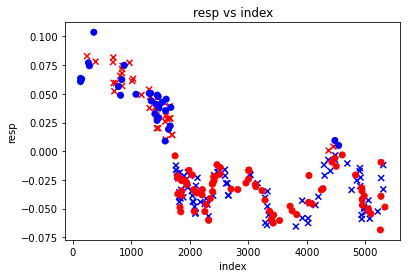

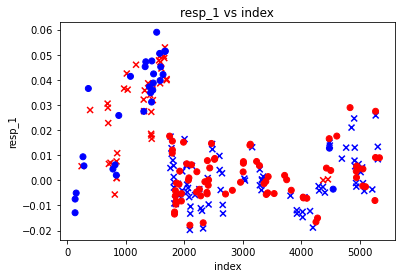

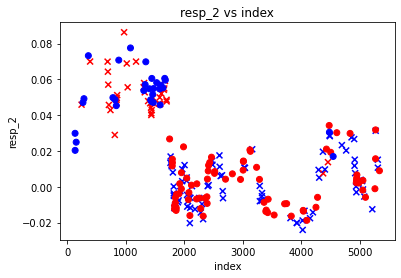

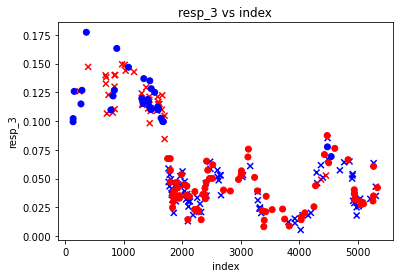

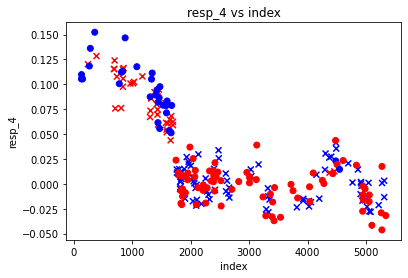

In [16]:
plot_cols(df_md_f0,['resp','resp_1','resp_2','resp_3','resp_4'])

In [17]:
def line_plot(data, col_1):
    x = data.index
    y = data[col_1].values
    plt.figure(figsize=(12,8))
    plt.plot(x,y)
    plt.xlabel('index')
    plt.ylabel(col_1)
    plt.title(col_1 + ' line plot')
    plot_acf(x)
    plt.show()
    result = adfuller(y)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print("\n",'-----'*20,'\n')

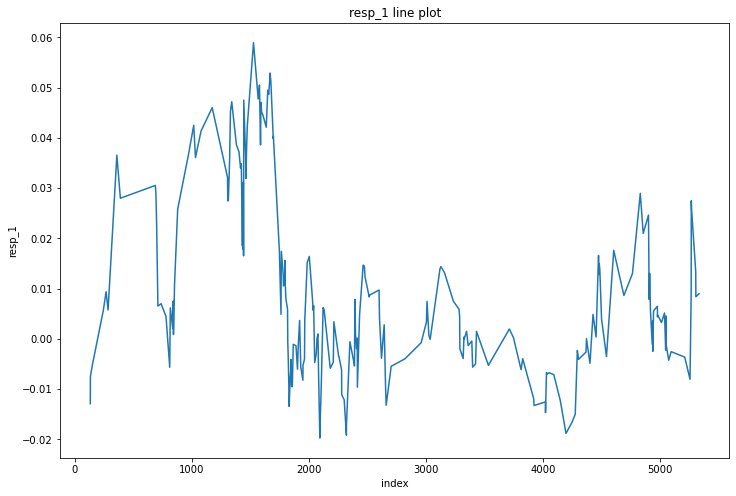

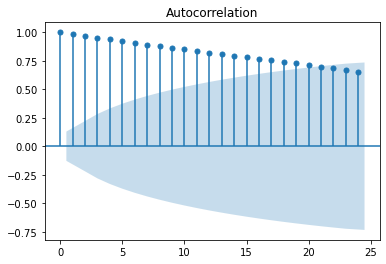

ADF Statistic: -2.945180
p-value: 0.040341
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574

 ---------------------------------------------------------------------------------------------------- 



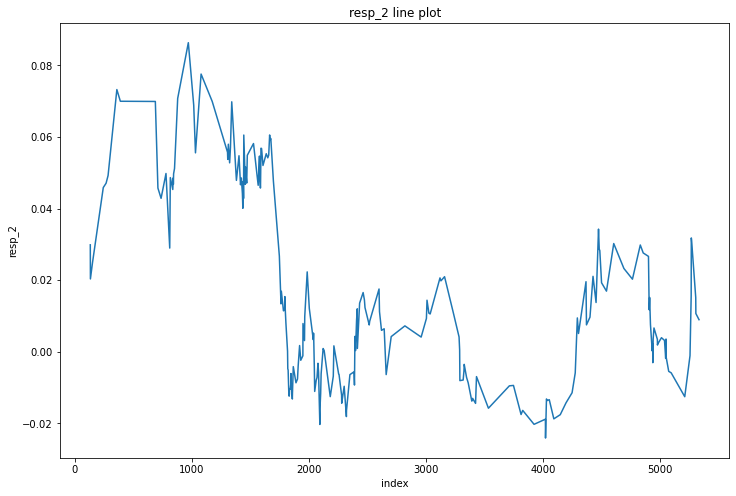

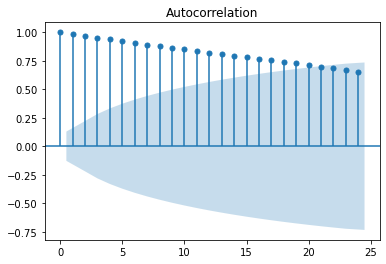

ADF Statistic: -1.974506
p-value: 0.297862
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574

 ---------------------------------------------------------------------------------------------------- 



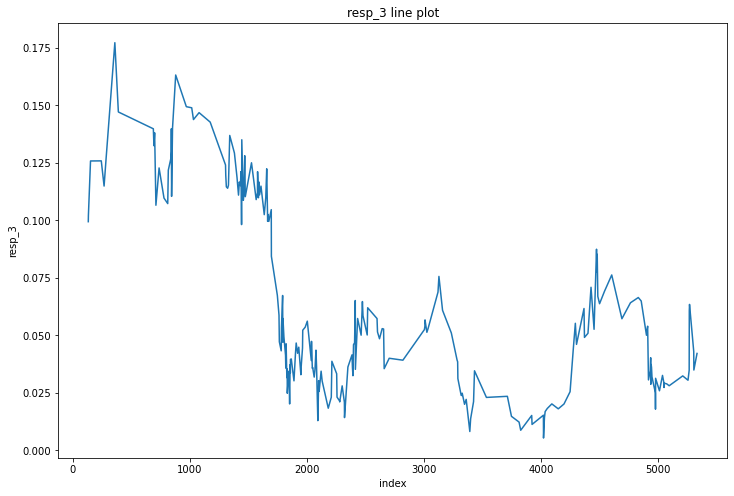

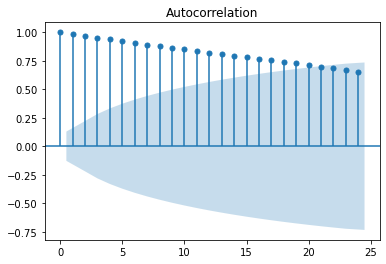

ADF Statistic: -1.724595
p-value: 0.418487
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574

 ---------------------------------------------------------------------------------------------------- 



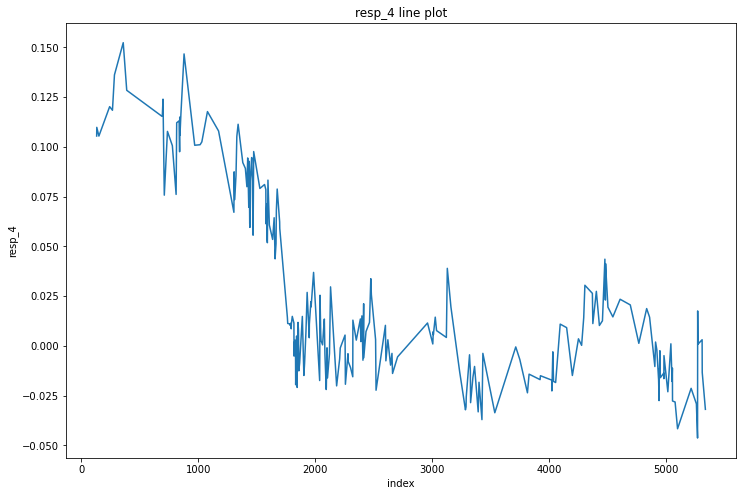

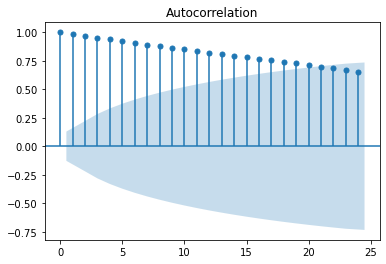

ADF Statistic: -1.955461
p-value: 0.306437
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574

 ---------------------------------------------------------------------------------------------------- 



In [18]:
for i in range(1,5):
    line_plot(df_md_f0,f'resp_{i}')

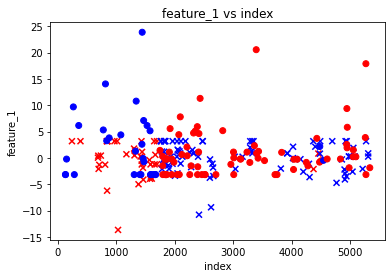

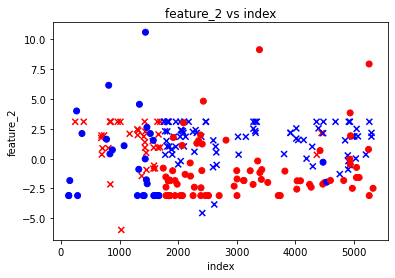

In [19]:
plot_cols(df_md_f0,['feature_1','feature_2'])

In [20]:
#functino to view features vs features
def feat_vs_feat(data, col_1, col_2):
    fig,ax = plt.subplots()    
    colors = {0:'red', 1:'blue'}
    markers = {-1:'x', 1:'o'}
    
    x = data[col_1].values
    y = data[col_2].values
    c = data['action'].map(colors)
    m = data['feature_0'].map(markers)
    
    unique_markers = set(m)
    
    for um in unique_markers:
        mask = m == um
        ax.scatter(x[mask],y[mask],c=c[mask], marker=um)
        ax.set_title(col_2 + ' vs ' + col_1)
        ax.set_xlabel(col_1)
        ax.set_ylabel(col_2)
    plt.show()

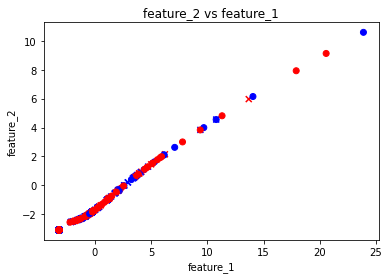

In [21]:
feat_vs_feat(df_md, 'feature_1','feature_2')

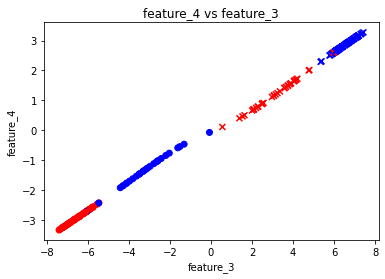

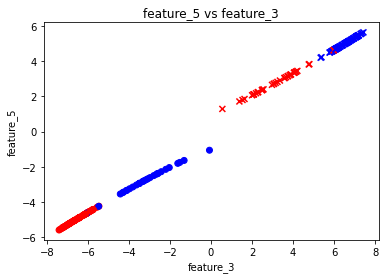

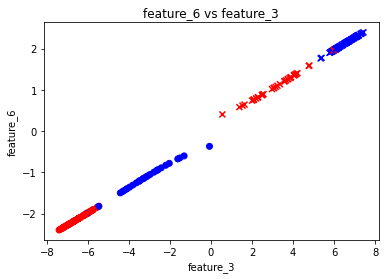

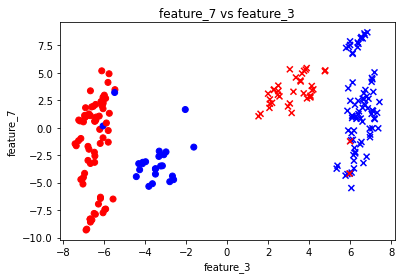

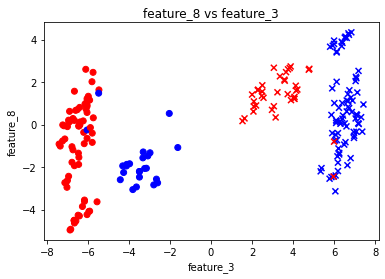

In [22]:
for i in range(4,9):
    feat_vs_feat(df_md, 'feature_3',f'feature_{i}')

from the features_hot table we can see that feature_0 has all it's tags equal to false or zero. We are trying to see if there are any other features that have the same characteristic

In [105]:
def check_feature_tags(data, feature, feature_compare):
    array_pivot = data.loc[data.feature == feature_compare].values[0]
    array = data.loc[data.feature == feature].values[0]
    if np.array_equal(array,array_pivot):
        return(True,feature)
    else:
        return False

answers = []
for i in range(1,130):
    answer = check_feature_tags(features_hot,f'feature_{i}','feature_0')
    answers.append(answer)

In [96]:
print(any(answers))

False


No feature has the same characteristic as feature_0 with all tags equal to zero or false. maybe thats why multiplying by feature_0 gives a trend to our data.